In [3]:
from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
file_path = '/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/data/serie_temporal_prueba.csv'
df = pd.read_csv(file_path)

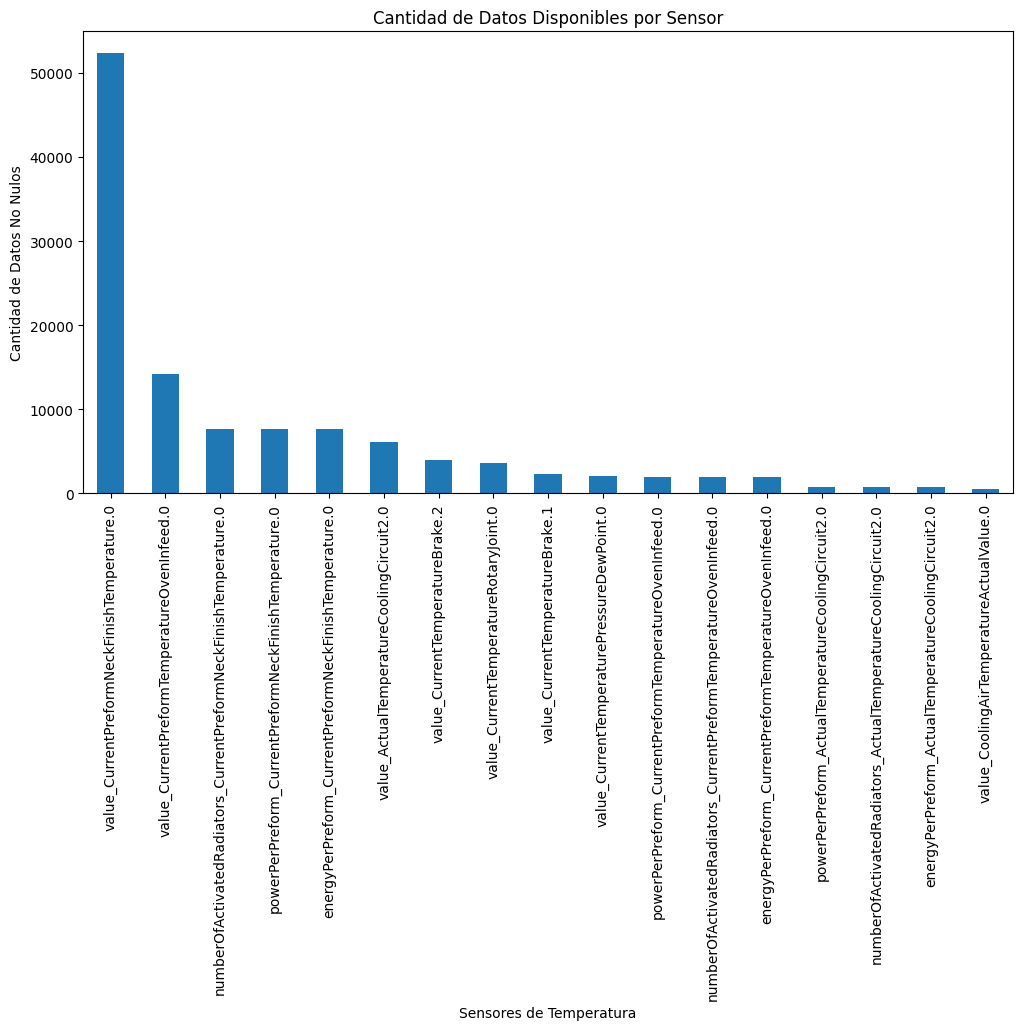

In [5]:
# Visualizar cantidad de datos por sensor
non_null_counts = df.drop(columns=['user_ts__']).count().sort_values(ascending=False)
plt.figure(figsize=(12,6))
non_null_counts.plot(kind='bar')
plt.xlabel("Sensores de Temperatura")
plt.ylabel("Cantidad de Datos No Nulos")
plt.title("Cantidad de Datos Disponibles por Sensor")
plt.xticks(rotation=90)
plt.show()

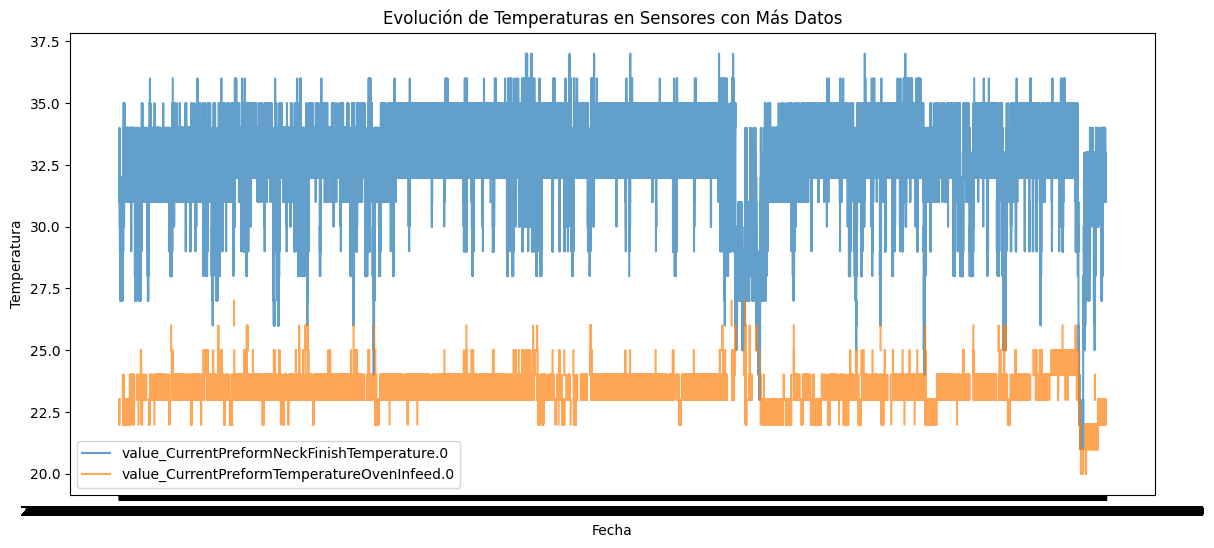

In [6]:
# Seleccionar algunas columnas con más datos
selected_columns = ["value_CurrentPreformNeckFinishTemperature.0", "value_CurrentPreformTemperatureOvenInfeed.0"]

# Filtrar solo filas con datos en esas columnas
df_selected = df[['user_ts__'] + selected_columns].dropna(subset=selected_columns, how='all')

# Graficar las series temporales
plt.figure(figsize=(14,6))
for col in selected_columns:
    plt.plot(df_selected['user_ts__'], df_selected[col], label=col, alpha=0.7)

plt.xlabel("Fecha")
plt.ylabel("Temperatura")
plt.title("Evolución de Temperaturas en Sensores con Más Datos")
plt.legend()
plt.show()

In [20]:
# Seleccionar la columna con más datos
target_column = "value_CurrentPreformNeckFinishTemperature.0"
df_sensor = df[['user_ts__', target_column]].dropna()
df_sensor.set_index('user_ts__', inplace=True)

# Reducir datos a los últimos 2000 registros
df_sensor = df_sensor.tail(2400)

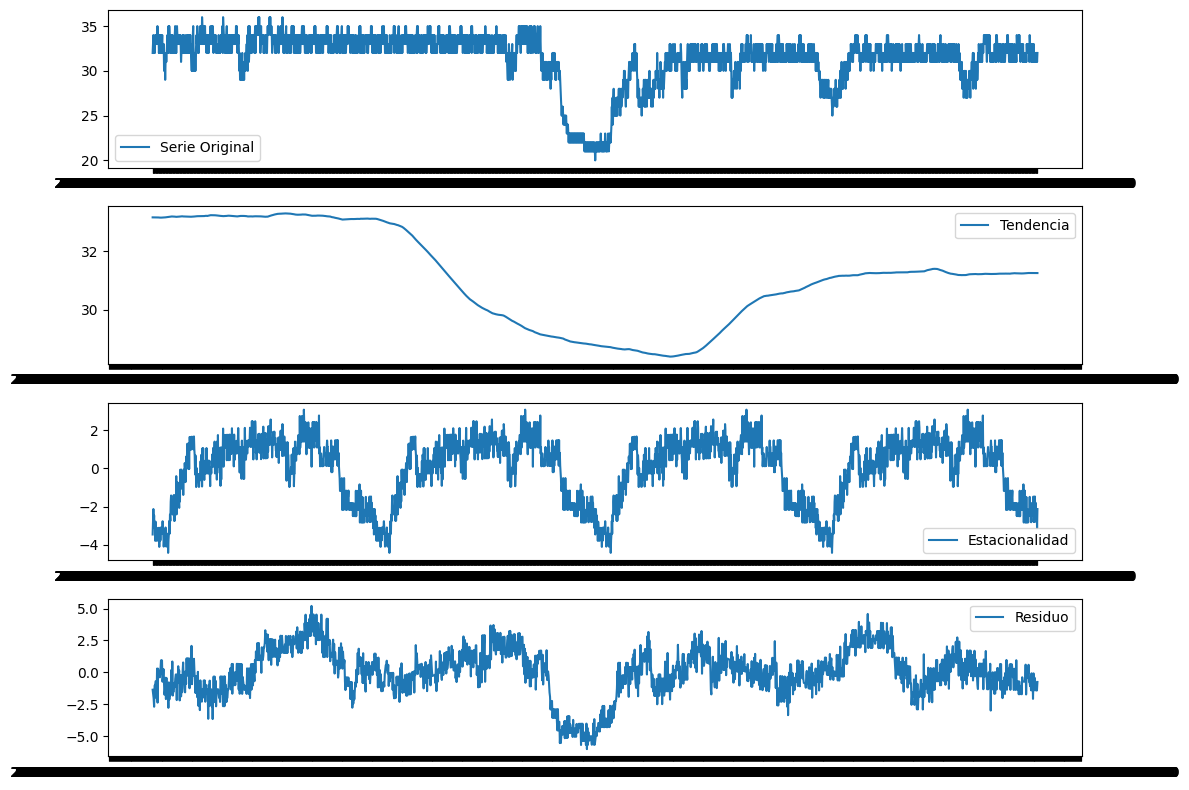

In [21]:
# Descomposición de la serie temporal
result = seasonal_decompose(df_sensor[target_column], model='additive', period=600)
plt.figure(figsize=(12,8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Serie Original')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuo')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Encontrar el mejor modelo ARIMA automáticamente
auto_model = auto_arima(df_sensor[target_column], seasonal=True, m=600, trace=True, suppress_warnings=True)

/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' w

Performing stepwise search to minimize aic


: 

In [ ]:
# Obtener los mejores parámetros
best_order = auto_model.order  # (p,d,q)
best_seasonal_order = auto_model.seasonal_order  # (P,D,Q,s)

In [ ]:
# Entrenar SARIMAX con los mejores parámetros encontrados
model = SARIMAX(df_sensor[target_column], order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = model.fit(disp=False)

In [ ]:
# Generar predicciones
df_sensor['predicted'] = sarimax_fit.predict(start=0, end=len(df_sensor)-1, dynamic=False)

In [ ]:
# Graficar observaciones vs predicciones
plt.figure(figsize=(12,6))
plt.plot(df_sensor.index, df_sensor[target_column], label="Observado", alpha=0.7)
plt.plot(df_sensor.index, df_sensor['predicted'], label="Predicción SARIMAX", linestyle="dashed", alpha=0.9)
plt.xlabel("Fecha")
plt.ylabel("Temperatura")
plt.title("Modelo SARIMAX Optimizado con auto_arima")
plt.legend()
plt.show()

In [ ]:
# Evaluar el modelo
mae = mean_absolute_error(df_sensor[target_column], df_sensor['predicted'])
rmse = np.sqrt(mean_squared_error(df_sensor[target_column], df_sensor['predicted']))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

In [ ]:
# Detección de anomalías: diferencias grandes entre predicción y realidad
df_sensor['error'] = np.abs(df_sensor[target_column] - df_sensor['predicted'])
thresh = df_sensor['error'].mean() + 2 * df_sensor['error'].std()
df_anomalies = df_sensor[df_sensor['error'] > thresh]

# Graficar anomalías
plt.figure(figsize=(12,6))
plt.plot(df_sensor.index, df_sensor[target_column], label="Observado", alpha=0.7)
plt.plot(df_sensor.index, df_sensor['predicted'], label="Predicción SARIMAX", linestyle="dashed", alpha=0.9)
plt.scatter(df_anomalies.index, df_anomalies[target_column], color='red', label='Anomalías', zorder=3)
plt.xlabel("Fecha")
plt.ylabel("Temperatura")
plt.title("Detección de Anomalías con SARIMAX")
plt.legend()
plt.show()

# Mostrar anomalías
df_anomalies

***Training and Test Set***

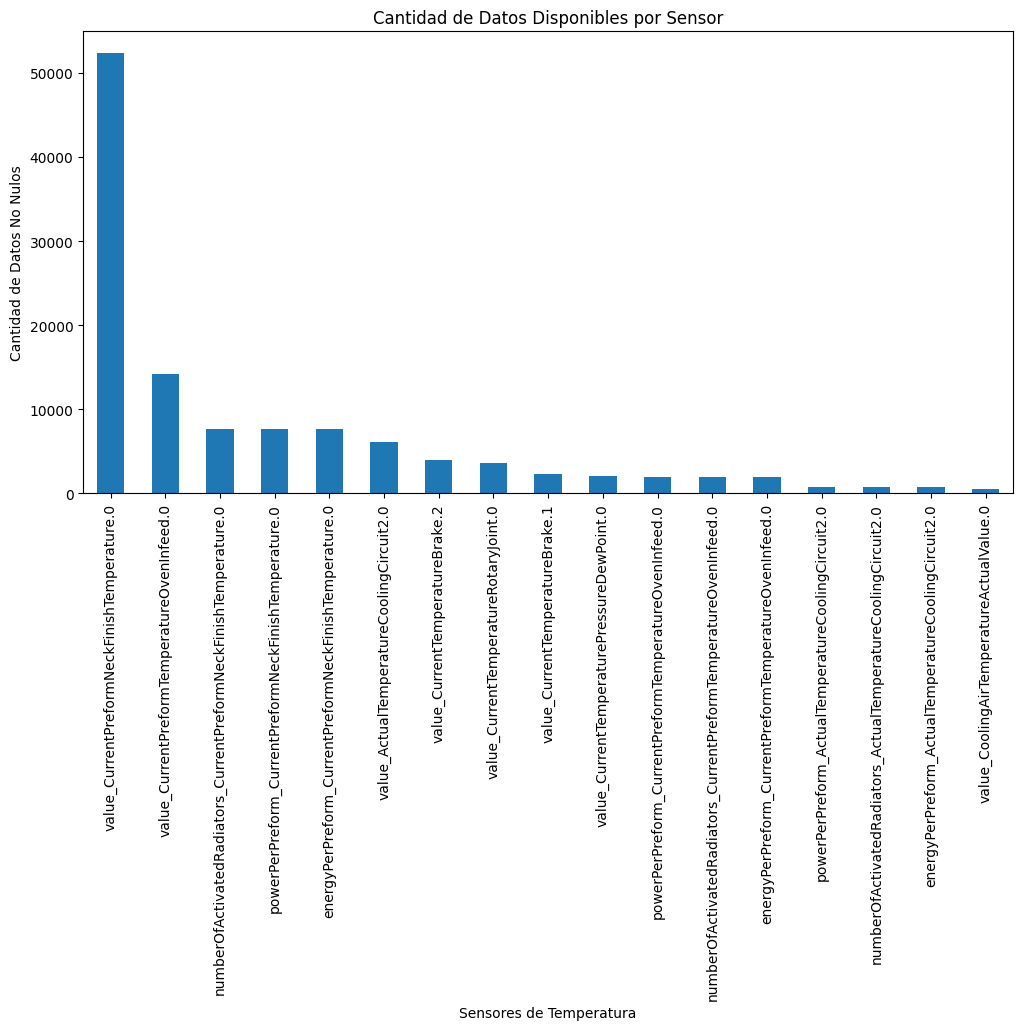

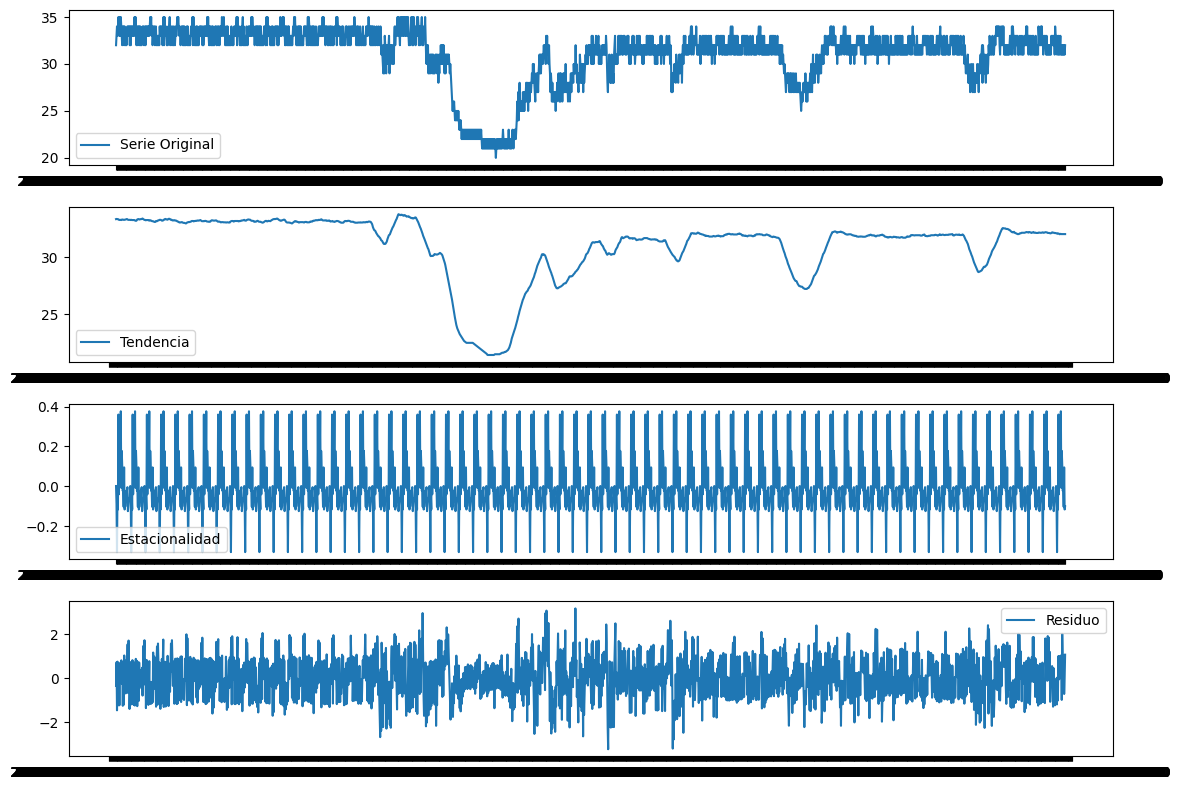

/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' w

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=7.11 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=7226.596, Time=0.02 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=5854.772, Time=0.49 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=5907.841, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=7224.596, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=5852.949, Time=0.03 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' w

 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=5854.771, Time=0.58 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=5856.772, Time=0.63 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=5657.731, Time=0.05 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[30] intercept   : AIC=5659.667, Time=1.05 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[30] intercept   : AIC=5659.667, Time=0.68 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[30] intercept   : AIC=5661.664, Time=1.16 sec
 ARIMA(3,1,0)(0,0,0)[30] intercept   : AIC=5645.896, Time=0.05 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[30] intercept   : AIC=5647.778, Time=1.11 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[30] intercept   : AIC=5647.779, Time=0.75 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[30] intercept   : AIC=5649.783, Time=1.35 sec
 ARIMA(4,1,0)(0,0,0)[30] intercept   : AIC=5632.771, Time=0.12 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[30] intercept   : AIC=5634.698, Time=1.47 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[30] intercept   : AIC=5634.699, Time=0.84 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,1)[30] intercept   : AIC=5636.702, Time=1.61 sec
 ARIMA(5,1,0)(0,0,0)[30] intercept   : AIC=5621.299, Time=0.14 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,0)[30] intercept   : AIC=5623.094, Time=1.55 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(0,0,1)[30] intercept   : AIC=5623.096, Time=1.00 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,0)(1,0,1)[30] intercept   : AIC=5625.104, Time=1.71 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[30] intercept   : AIC=5617.260, Time=0.38 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,0)[30] intercept   : AIC=5619.014, Time=3.16 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,1)[30] intercept   : AIC=5619.019, Time=3.68 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(1,0,1)[30] intercept   : AIC=5621.028, Time=3.49 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[30] intercept   : AIC=5617.689, Time=0.32 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[30] intercept   : AIC=5616.865, Time=0.56 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(1,0,0)[30] intercept   : AIC=5618.546, Time=5.37 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,1)[30] intercept   : AIC=5618.552, Time=7.92 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=8.35 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[30] intercept   : AIC=inf, Time=0.71 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[30] intercept   : AIC=5616.681, Time=0.82 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(1,0,0)[30] intercept   : AIC=5618.371, Time=8.66 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,1)[30] intercept   : AIC=5618.377, Time=8.04 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(1,0,1)[30] intercept   : AIC=5620.347, Time=8.30 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[30] intercept   : AIC=5614.976, Time=0.57 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(1,0,0)[30] intercept   : AIC=5616.631, Time=6.36 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,1)[30] intercept   : AIC=5616.638, Time=6.60 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(1,0,1)[30] intercept   : AIC=5617.913, Time=9.05 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[30] intercept   : AIC=5614.813, Time=0.48 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,0)[30] intercept   : AIC=5616.482, Time=5.71 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,1)[30] intercept   : AIC=5616.490, Time=5.44 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,1)[30] intercept   : AIC=inf, Time=8.66 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[30] intercept   : AIC=5615.885, Time=0.35 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[30] intercept   : AIC=5618.763, Time=0.32 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[30] intercept   : AIC=5615.441, Time=0.76 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=5626.789, Time=0.25 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[30] intercept   : AIC=5616.224, Time=0.62 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[30] intercept   : AIC=5616.515, Time=0.95 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[30]             : AIC=5612.823, Time=0.45 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,0)[30]             : AIC=5614.492, Time=1.95 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,1)[30]             : AIC=5614.500, Time=2.07 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,1)[30]             : AIC=inf, Time=4.91 sec
 ARIMA(2,1,3)(0,0,0)[30]             : AIC=5613.896, Time=0.15 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[30]             : AIC=5616.773, Time=0.25 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[30]             : AIC=5612.985, Time=0.34 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[30]             : AIC=5613.450, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[30]             : AIC=5624.796, Time=0.10 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[30]             : AIC=5614.233, Time=0.48 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[30]             : AIC=5618.614, Time=0.51 sec


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[30]             : AIC=5614.525, Time=0.55 sec

Best model:  ARIMA(3,1,3)(0,0,0)[30]          
Total fit time: 143.350 seconds


/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/angelgovea/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/4to Semestre/Analisis de Ciencia de Datos/PISA_VertizSanchezGovea/.venv_3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/0p/v_8rs5px14l8lggm7z70s1dw0000gn/T/ipykernel_84579/4052231215.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

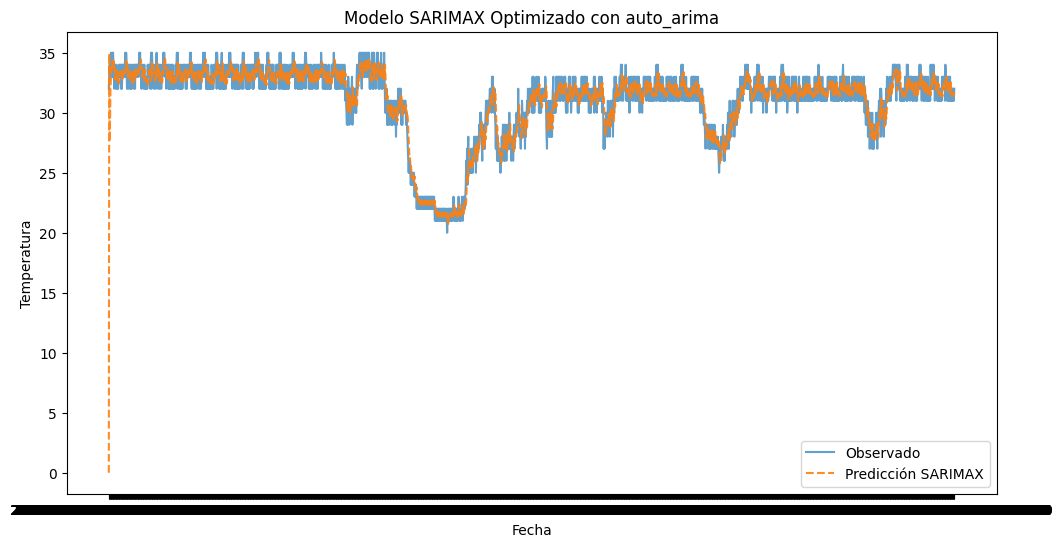

MAE: 0.7910630988782557
RMSE: 1.226601021138753


/var/folders/0p/v_8rs5px14l8lggm7z70s1dw0000gn/T/ipykernel_84579/4052231215.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['error'] = np.abs(df_small[target_column] - df_small['predicted'])


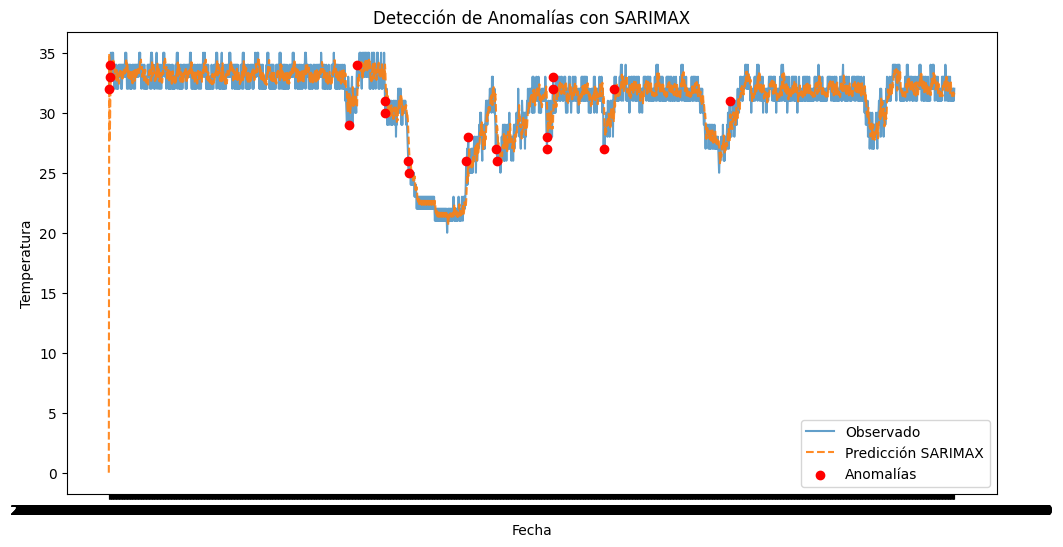

,value_CurrentPreformNeckFinishTemperature.0,predicted,error
user_ts__,,,
2025-01-14 15:48:44+00:00,32.0,0.000000,32.000000
2025-01-14 15:48:48+00:00,34.0,27.612528,6.387472
2025-01-14 15:48:49+00:00,33.0,29.297898,3.702102
2025-01-14 16:02:05+00:00,29.0,31.726576,2.726576
2025-01-14 16:02:27+00:00,34.0,30.597399,3.402601
2025-01-14 16:04:05+00:00,31.0,34.016925,3.016925
2025-01-14 16:04:06+00:00,30.0,33.347292,3.347292
2025-01-14 16:14:55+00:00,26.0,28.667261,2.667261
2025-01-14 16:18:14+00:00,25.0,27.740697,2.740697


In [ ]:


# Encontrar el mejor modelo ARIMA automáticamente
auto_model = auto_arima(df_small[target_column], seasonal=True, m=30, trace=True, suppress_warnings=True)

# Obtener los mejores parámetros
best_order = auto_model.order  # (p,d,q)
best_seasonal_order = auto_model.seasonal_order  # (P,D,Q,s)

# Entrenar SARIMAX con los mejores parámetros encontrados
model = SARIMAX(df_small[target_column], order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = model.fit(disp=False)

# Generar predicciones
df_small['predicted'] = sarimax_fit.predict(start=0, end=len(df_small)-1, dynamic=False)

# Graficar observaciones vs predicciones
plt.figure(figsize=(12,6))
plt.plot(df_small.index, df_small[target_column], label="Observado", alpha=0.7)
plt.plot(df_small.index, df_small['predicted'], label="Predicción SARIMAX", linestyle="dashed", alpha=0.9)
plt.xlabel("Fecha")
plt.ylabel("Temperatura")
plt.title("Modelo SARIMAX Optimizado con auto_arima")
plt.legend()
plt.show()

# Evaluar el modelo
mae = mean_absolute_error(df_small[target_column], df_small['predicted'])
rmse = np.sqrt(mean_squared_error(df_small[target_column], df_small['predicted']))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Detección de anomalías: diferencias grandes entre predicción y realidad
df_small['error'] = np.abs(df_small[target_column] - df_small['predicted'])
thresh = df_small['error'].mean() + 2 * df_small['error'].std()
df_anomalies = df_small[df_small['error'] > thresh]

# Graficar anomalías
plt.figure(figsize=(12,6))
plt.plot(df_small.index, df_small[target_column], label="Observado", alpha=0.7)
plt.plot(df_small.index, df_small['predicted'], label="Predicción SARIMAX", linestyle="dashed", alpha=0.9)
plt.scatter(df_anomalies.index, df_anomalies[target_column], color='red', label='Anomalías', zorder=3)
plt.xlabel("Fecha")
plt.ylabel("Temperatura")
plt.title("Detección de Anomalías con SARIMAX")
plt.legend()
plt.show()

# Mostrar anomalías
df_anomalies
